# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [11]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-6, 5e-6, 5e-5, 3e-4]
regularization_strengths = [5e-1, 5e2, 5e3]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print(lr, reg)
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            print("best accuracy so far: ", best_val)
            best_svm = svm
        results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-06 0.5
best accuracy so far:  0.27
1e-06 500.0
best accuracy so far:  0.296
1e-06 5000.0
best accuracy so far:  0.418
5e-06 0.5
5e-06 500.0
best accuracy so far:  0.419
5e-06 5000.0
best accuracy so far:  0.42
5e-05 0.5
best accuracy so far:  0.429
5e-05 500.0
5e-05 5000.0
0.0003 0.5
best accuracy so far:  0.48
0.0003 500.0
0.0003 5000.0
lr 1.000000e-06 reg 5.000000e-01 train accuracy: 0.260020 val accuracy: 0.270000
lr 1.000000e-06 reg 5.000000e+02 train accuracy: 0.305429 val accuracy: 0.296000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.416020 val accuracy: 0.418000
lr 5.000000e-06 reg 5.000000e-01 train accuracy: 0.392286 val accuracy: 0.373000
lr 5.000000e-06 reg 5.000000e+02 train accuracy: 0.415612 val accuracy: 0.419000
lr 5.000000e-06 reg 5.000000e+03 train accuracy: 0.415551 val accuracy: 0.420000
lr 5.000000e-05 reg 5.000000e-01 train accuracy: 0.430898 val accuracy: 0.429000
lr 5.000000e-05 reg 5.000000e+02 train accuracy: 0.415918 val accuracy: 0.410000
lr 5.0000

In [15]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.478


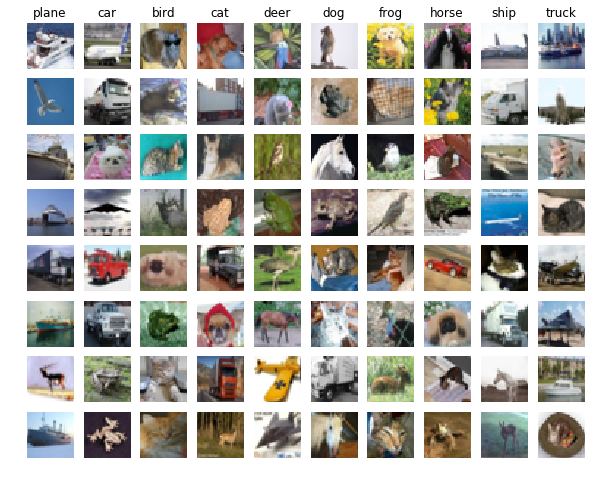

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Images have been classified wrongly because of thier surroundings. For example, some planes are classified as birds and some birds as planes because both fly in the sky and the background is blue. The misclassifciations are due to lack variety in backgrounds of images in training set and hence the background serves as part of the object's identity. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
print(X_train_feats.shape)

(49000, 155)


In [37]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
# learning_rates = [5e-3, 1e-3, 5e-2]
# regularization_strengths = [.7, .5, .6]
# learning_rate_decay=[0.996, 0.9, 0.8]
# num_iters = [700, 1500, 1800]
# results ={}
# best_val = 0
# for ni in num_iters:
#     for lrd in learning_rate_decay:
#         for lr in learning_rates:
#             for reg in regularization_strengths:
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=500,
            learning_rate=1, learning_rate_decay=.95, reg=5e-3, verbose=True)
#                 val_acc = (net.predict(X_val) == y_val).mean()
#                 print(val_acc)
#                 results[(lr,reg)] = val_acc
        
#                 if best_val < val_acc:
#                     best_val = val_acc
#                     best_net = net

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 1.516237
iteration 200 / 1000: loss 1.504235
iteration 300 / 1000: loss 1.413950
iteration 400 / 1000: loss 1.493807
iteration 500 / 1000: loss 1.407445
iteration 600 / 1000: loss 1.426856
iteration 700 / 1000: loss 1.480206
iteration 800 / 1000: loss 1.408458
iteration 900 / 1000: loss 1.452373
Validation accuracy:  0.557


In [38]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.551


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.


- Implemented SIFT, Harris Corner Detection, Adam Optimizer, and data augmentation below. Sift gets the features and their descriptors; the legnth of each feature vector was decreased to 9x128 to allow training. This should be better than norm because it uses key points as it's training features. Also Harris corner detector adds more distinguishing features (corners). This finds corners and uses bins to categorize these. It has a  blockSize of 2, ksize of 3, and k (free parameter) of .04. These can be adjusted to get better results. I tried implementing this to see if this feature detector woudl do better; however this performed poorly as well. More hyperparamter tuning is needed.  The descriptors are averaged to serve as the features in training. I also used data augmentation to better the results. I rotated the images and added them to the dataset. Finally, I used Adam Optimizer to adjust the values of W better. This process takes into account momentum in computing its chages. However, this still did not perform better than the SVM above. After testing MANY hyper parameters, I'm not sure the origin of this problem. It only achieved 27% accuracy. 

In [88]:
from cs231n.data_utils import load_CIFAR10
from cs231n.classifiers.neural_net import TwoLayerNet
import numpy as np
import cv2
from cs231n.features import *

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), lambda img: getSIFT(img), lambda img: getHarris(img)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

print('done processing')


/home/amr6114/assignment1/cs231n/features.py:161: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(des == None):


Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [89]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


best_net = None

lrexp = np.random.uniform(-7, 0, 10)
learning_rates = [.2, .1] #np.power(10, d) for d in lrexp]
regexp = np.random.uniform(-5, 0, 10)
regularization_strengths = [5e-5, 5e-4]#np.power(10, d) for d in regexp]
results = {}
best_val = -1
learning_rate_decay=[0.95]
num_iters = [1000]


for ni in num_iters:
    for lrd in learning_rate_decay:
        for lr in learning_rates:
            for reg in regularization_strengths:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                print(lr, reg)
                lost_hist = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=ni, batch_size=500,learning_rate=lr, 
                                      learning_rate_decay=lrd, reg=reg, verbose=True)
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                results[(lr,reg)] = val_acc
                print(lr, reg, val_acc)
        
                if best_val < val_acc:
                    best_val = val_acc
                    best_net = net
                    print("BEST: ", val_acc)

# Print out results.
for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('Validation accuracy: ', val_acc)
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

0.2 5e-05
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.927629
iteration 200 / 1000: loss 1.404081
iteration 300 / 1000: loss 1.257131
iteration 400 / 1000: loss 1.226398
iteration 500 / 1000: loss 1.185351
iteration 600 / 1000: loss 1.158465
iteration 700 / 1000: loss 1.090276
iteration 800 / 1000: loss 0.967063
iteration 900 / 1000: loss 0.902102
0.2 5e-05 0.546
BEST:  0.546
0.2 0.0005
iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 1.937164
iteration 200 / 1000: loss 1.443257
iteration 300 / 1000: loss 1.350601
iteration 400 / 1000: loss 1.245555
iteration 500 / 1000: loss 1.125999
iteration 600 / 1000: loss 1.061181
iteration 700 / 1000: loss 1.011911
iteration 800 / 1000: loss 1.066529
iteration 900 / 1000: loss 0.989640
0.2 0.0005 0.538
0.1 5e-05
iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 2.254336
iteration 200 / 1000: loss 1.944952
iteration 300 / 1000: loss 1.617302
iteration 400 / 1000: loss 1.424023
iteration 500 / 1000: loss 1.

In [91]:
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.521


Also doing variations of image:

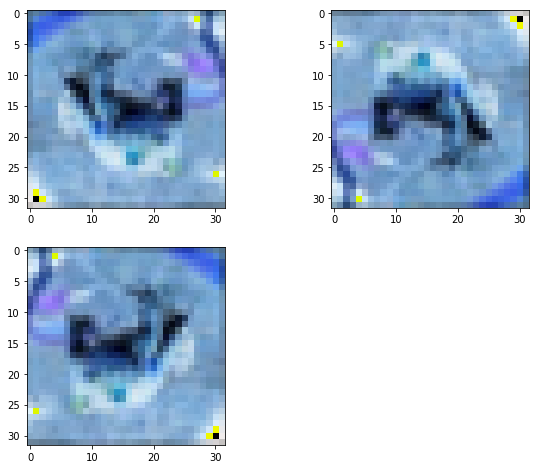

In [96]:
img = X_train[0]
 
# copy image to display all 4 variations
horizontal_img = img.copy()
vertical_img = img.copy()
both_img = img.copy()
 
# flip img horizontally, vertically,
# and both axes with flip()
horizontal_img = cv2.flip( img, 0 )
vertical_img = cv2.flip( img, 1 )
both_img = cv2.flip( img, -1 )
 
fig = plt.figure()
plt.subplot(221)
plt.imshow(horizontal_img)
plt.subplot(222)
plt.imshow(vertical_img)
plt.subplot(223)
plt.imshow(both_img)

In [104]:
from cs231n.data_utils import load_CIFAR10
from cs231n.classifiers.neural_net import TwoLayerNet
import numpy as np
import cv2
from cs231n.features import *

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()


xtrain1 = np.array([cv2.flip( img, 0 ) for d in X_train])
xval1 = np.array([cv2.flip( img, 0 ) for d in X_val])
xtrain2 = np.array([cv2.flip( img, 1 ) for d in X_train])
xval2 = np.array([cv2.flip( img, 1 ) for d in X_val])
xtrain3 = np.array([cv2.flip( img, -1 ) for d in X_train])
xval3 = np.array([cv2.flip( img, -1 ) for d in X_val])

print(X_train.shape, xtrain1.shape, xtrain2.shape, xtrain3.shape)

X_train = np.concatenate((X_train, xtrain1))
X_train = np.concatenate((X_train, xtrain2))
X_train = np.concatenate((X_train, xtrain3))

y_train = np.concatenate((y_train, y_train))
y_train = np.concatenate((y_train, y_train))
y_train = np.concatenate((y_train, y_train))

X_val = np.concatenate((X_val, xval1))
X_val = np.concatenate((X_val, xval2))
X_val = np.concatenate((X_val, xval3)) 

y_val = np.concatenate((y_val, y_val))
y_val = np.concatenate((y_val, y_val))
y_val = np.concatenate((y_val, y_val)) 


num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), lambda img: getSIFT(img)]#, lambda img: getHarris(img)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

print('done processing')


(49000, 32, 32, 3) (49000, 32, 32, 3) (49000, 32, 32, 3) (49000, 32, 32, 3)


/home/amr6114/assignment1/cs231n/features.py:161: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(des == None):


Done extracting features for 1000 / 196000 images
Done extracting features for 2000 / 196000 images
Done extracting features for 3000 / 196000 images
Done extracting features for 4000 / 196000 images
Done extracting features for 5000 / 196000 images
Done extracting features for 6000 / 196000 images
Done extracting features for 7000 / 196000 images
Done extracting features for 8000 / 196000 images
Done extracting features for 9000 / 196000 images
Done extracting features for 10000 / 196000 images
Done extracting features for 11000 / 196000 images
Done extracting features for 12000 / 196000 images
Done extracting features for 13000 / 196000 images
Done extracting features for 14000 / 196000 images
Done extracting features for 15000 / 196000 images
Done extracting features for 16000 / 196000 images
Done extracting features for 17000 / 196000 images
Done extracting features for 18000 / 196000 images
Done extracting features for 19000 / 196000 images
Done extracting features for 20000 / 196

Done extracting features for 161000 / 196000 images
Done extracting features for 162000 / 196000 images
Done extracting features for 163000 / 196000 images
Done extracting features for 164000 / 196000 images
Done extracting features for 165000 / 196000 images
Done extracting features for 166000 / 196000 images
Done extracting features for 167000 / 196000 images
Done extracting features for 168000 / 196000 images
Done extracting features for 169000 / 196000 images
Done extracting features for 170000 / 196000 images
Done extracting features for 171000 / 196000 images
Done extracting features for 172000 / 196000 images
Done extracting features for 173000 / 196000 images
Done extracting features for 174000 / 196000 images
Done extracting features for 175000 / 196000 images
Done extracting features for 176000 / 196000 images
Done extracting features for 177000 / 196000 images
Done extracting features for 178000 / 196000 images
Done extracting features for 179000 / 196000 images
Done extract

In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

y_train = np.concatenate((y_train, y_train))
y_train = np.concatenate((y_train, y_train))
y_train = np.concatenate((y_train, y_train))
y_val = np.concatenate((y_val, y_val))
y_val = np.concatenate((y_val, y_val))
y_val = np.concatenate((y_val, y_val)) 

print(X_val_feats.shape, y_val.shape)

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


best_net = None

lrexp = np.random.uniform(-7, 0, 10)
learning_rates = [.2, .1] #np.power(10, d) for d in lrexp]
regexp = np.random.uniform(-5, 0, 10)
regularization_strengths = [5e-5, 5e-4]#np.power(10, d) for d in regexp]
results = {}
best_val = -1
learning_rate_decay=[0.95]
num_iters = [1000]


for ni in num_iters:
    for lrd in learning_rate_decay:
        for lr in learning_rates:
            for reg in regularization_strengths:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                print(lr, reg)
                lost_hist = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=ni, batch_size=500,learning_rate=lr, 
                                      learning_rate_decay=lrd, reg=reg, verbose=True)
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                results[(lr,reg)] = val_acc
                print(lr, reg, val_acc)
        
                if best_val < val_acc:
                    best_val = val_acc
                    best_net = net
                    print("BEST: ", val_acc)

# Print out results.
for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('Validation accuracy: ', val_acc)
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!
